## Library Imports

In [48]:
from whoosh import index, writing, scoring
from whoosh.fields import Schema, TEXT, KEYWORD, ID, STORED
from whoosh.analysis import *
from whoosh.qparser import QueryParser
from nltk.tokenize import *
import os, os.path
import shutil
import pandas as pd
import re
from tqdm import tqdm
from nltk.tokenize.moses import MosesTokenizer 
from nltk.tokenize.moses import MosesDetokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics 
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [53]:
# Create tokenizer and detokenizer for future use
tokenizer = MosesTokenizer()
detokenizer = MosesDetokenizer()

## File Imports

In [15]:
# List file locations for inputs
classified_tweets_path = "classified_tweets.txt"
unclassified_tweets_path = "unclassified_tweets.txt"
stop_words_path = "stop_words.txt"

In [54]:
# Read stop words
with open(stop_words_path) as f:
    stop_words = f.readlines()
stop_words = [x.strip('\n') for x in stop_words]

In [17]:
# Read classified tweets into dataframe
classified_tweets = pd.read_csv(classified_tweets_path,encoding="utf-8", usecols=['class','text'])
classified_tweets.head()

,class,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [72]:
# Read raw unclassified tweets
with open(unclassified_tweets_path) as f:
    unclassified_tweets = f.readlines()

# Strip new lines and blanks lines from unclassified tweets
unclassified_tweets_temp = []
for line in unclassified_tweets:
    if line.strip():
        unclassified_tweets_temp.append(line)
unclassified_tweets_temp = [x.strip('\n') for x in unclassified_tweets_temp]

# Write to dataframe
unclassified_tweets = pd.DataFrame(unclassified_tweets_temp,columns=['text'])
unclassified_tweets.head()

,text
0,﻿living the dream. #cameraman #camera #camerac...
1,justin #trudeau's reasons for thanksgiving. to...
2,@themadape butt…..butt…..we’re allergic to l...
3,2 massive explosions at peace march in #turkey...
4,#mulcair suggests there’s bad blood between hi...


## 1. Clean tweets
Prepare tweets for further analysis

In [73]:
def tweet_cleaner(tweet_df):
    '''
    Function to clean and tokenize the 'text' column of a dataframe.
    Input: dataframe with 'text' column populated with strings to be cleaned
    Output: input dataframe with 'text' column entries cleaned as follows:
        a) Remove HTML tags & attributes ******
        b) Replace HTML character codes with ASCII equivalent ********
        c) Remove URLs
        d) make text lowercase
        e) Remove stopwords
        f) Changed from string to list of tokens
    '''
    # Create NLTK filter to tokenize, switch to lowercase and remove stop words
    tokenizer = RegexTokenizer() | LowercaseFilter() | StopFilter()
    
    # Create Regex filter to remove URL's
    # Source: https://gist.github.com/gruber/249502
    url_regex = r'\b((?:[a-z][\w-]+:(?:\/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}\/?)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\)){0,}(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s\!()\[\]{};:\'\"\.\,<>?«»“”‘’‘’]){0,})'
    
    # Loop over all entries in 'text' column
    for i,tweet in enumerate(tweet_df.text.head(100)):
        # Remove urls
        tweet = re.sub(url_regex, "", tweet)
        
        # Tokenize, remove stop words, convert to lowercase
        tweet = [token.text for token in tokenizer(tweet)]
        
        # Detokenize
        tweet = detokenizer.detokenize(tweet, return_str=True)
        
        # Overwrite original value
        tweet_df.set_value(i,'text',tweet)

    return tweet_df

In [74]:
tweet_cleaner(unclassified_tweets)
unclassified_tweets.head()

,text
0,living dream cameraman camera cameraception ca...
1,justin trudeau reasons thanksgiving today mont...
2,themadape butt butt re allergic latex makes sn...
3,massive explosions peace march turkey 30 kille...
4,mulcair suggests there bad blood between him t...


In [75]:
tweet_cleaner(classified_tweets)
classified_tweets.head()

,class,text
0,0,switchfoot awww bummer shoulda got david carr ...
1,0,upset he update his facebook texting might cry...
2,0,kenichan dived many times ball managed save 50...
3,0,my whole body feels itchy like its fire
4,0,nationwideclass no behaving all mad why am her...


## 2. Exploratory Analysis
Assign political party to each tweet

In [85]:
def assign_party (tweet_df):
    '''
    Function to assign a political party to each tweet in column 'text'
    Input: dataframe with 'text' column populated with tweets
    Output: input dataframe with extra column categorizing the tweet as Conservative, Liberal, NDP or other 
    '''
    # Add column to dataframe for political party classification
    tweet_df['party'] = ''
    
    # Create list of words associated with each political party
    lib_list = ['justin','trudeau','justintrudeau', 'libéral', 'liberal', 'liberals','libs','lib', 'liberal_party',
                'lpc','ptlib','realchange','kathleen_wynne','mcguinty', 'yvonnejjones','teamtrudeau']
    con_list = ['stephenharper','steven', 'harper','stevenharper','conservative', 'cpc', 'pmharper','pm','pierrepoilievre',
                'poilievre','conservatives','pcers','pc','pttory','justnotready','duffy',
               'primeminister','prime','minister', 'tory', 'tories','canadianvalues','minjoeoliver',
               'premierministre','premierministreharper']
    ndp_list = ['tom','mulcair','thomasmulcair', 'tommulcair', 'ndp', 'ndp_hq','ptndp','ndp2015','whatwouldjackdo',
               'leap','rablaney']
    
    # Initialize counters for occurences of each party
    lib_count = 0
    con_count = 0
    npd_count = 0
    oth_count = 0
    
    # Assign party to each tweet
    for i,tweet in enumerate(tweet_df.text):
        # The score of a tweet with respect to a particular party is determined by how many words overlap with above associated words
        tweet = tokenizer.tokenize(tweet)
        lib_score = len(set(tweet) & set(lib_list))
        con_score = len(set(tweet) & set(con_list))
        ndp_score = len(set(tweet) & set(ndp_list))
        
        if (lib_score>con_score) & (lib_score>ndp_score):
            lib_count+=1
            tweet_df.set_value(i,'party','Liberal')
        elif (con_score>lib_score) & (con_score>ndp_score):
            con_count+=1
            tweet_df.set_value(i,'party','Conservative')
        elif (ndp_score>con_score) & (ndp_score>lib_score): 
            npd_count+=1
            tweet_df.set_value(i,'party','NDP')
#         elif (ndp_score==0) & (con_score==0) & (lib_score==0) :
        else:
            oth_count+=1
            tweet_df.set_value(i,'party','Other')

    print('lib_count: ',lib_count)
    print('con_count: ',con_count)
    print('npd_count: ',npd_count)
    print('oth_count: ',oth_count)
    
    # Print pyplot of tweet distributions by political party
    
    import matplotlib.pyplot as pyplt
 
    labels = ['Cookies', 'Jellybean', 'Milkshake', 'Cheesecake']
    sizes = [38.4, 40.6, 20.7, 10.3]
    colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
    patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90)
    pyplt.legend(patches, labels, loc="best")
    pyplt.axis('equal')
    pyplt.tight_layout()
    pyplt.show()
    
    return tweet_df

In [86]:
unclassified_tweets = assign_party(unclassified_tweets)

lib_count:  578
con_count:  625
npd_count:  300
oth_count:  1575


In [87]:
unclassified_tweets.head()

,text,party
0,living dream cameraman camera cameraception ca...,NDP
1,justin trudeau reasons thanksgiving today mont...,Liberal
2,themadape butt butt re allergic latex makes sn...,Other
3,massive explosions peace march turkey 30 kille...,Other
4,mulcair suggests there bad blood between him t...,NDP


## Model Preparation
Create logistic regression to predict if a tweet is positive or negative
The feature space will be created with term frequency-inverse document frequency scores which assigns values to a tweet according to the frequency of words within a twet as well as the rarity of that term within all documents(in theis case tweets). 

In [91]:
# Create vectorizer to score each word in each tweet according to (Term Frequency)*(Inverse Document Frequency)
vectorizer = TfidfVectorizer(stop_words=stop_words)

# create list of all tweets
tweet_list = []
for tweet in classified_tweets.text:
    tweet_list.append(tweet)

# Create TFIDF feature space
vocab = vectorizer.fit_transform(tweet_list)
vocab.get_shape()

(200000, 147540)

In [92]:
# Create target vector based on true sentiment
target = classified_tweets['class'].as_matrix()

In [36]:
# Create 70/30 train/test split of data
features_train, features_test, target_train, target_test = train_test_split(vocab, target, test_size=0.3)

In [37]:
# Initialize regression model
log_clf = LogisticRegression()

In [38]:
# Create Regression model on train split
clfModel = log_clf.fit(features_train, target_train)

In [39]:
# Create prediction for test split
target_pred = clfModel.predict(features_test)

In [90]:
print('The accuracy of the model is: ',100*metrics.accuracy_score(target_test, target_pred),'%')

The accuracy of the model is:  74.785 %


In [88]:
# Plot confusion matrix of true posivite, true negative, false positive, false negative predictions
pd.DataFrame(metrics.confusion_matrix(target_test, target_pred),
             columns=['Predicted Negative','Predicted Positive'],
             index=['True Negative','True Positive'])

,Predicted Negative,Predicted Positive
True Negative,21308,8830
True Positive,6299,23563


# Bonus Marks: Logistic Regression hyperparameter tuning
Explore logistic regression hyperparameters to improve model accuracy

In [135]:
# Create list of hyperparameters
params = np.logspace(-2, 2, num=15)
score = []

# Perform regression on each parameter c
for c in params:
    clf_hyp = LogisticRegression(C=c)
    clfModel_hyp = clf_hyp.fit(features_train, target_train)
    target_pred_hyp = clfModel_hyp.predict(features_test)
    score.append(metrics.accuracy_score(target_test, target_pred_hyp))
# print(params)
# print(score)

In [136]:
# Alternate method with Gridsearch and 5-fold cross validation
params = np.logspace(-2, 2, num=15)
param_grid = {'C': params }
log_clf_hyp = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
log_clf_hyp.fit(features_train, target_train)
# print(log_clf_hyp)
print('Highest Accuracy: ',log_clf_hyp.best_score_)
print('Best Estimator: ',log_clf_hyp.best_estimator_.C)

Highest Accuracy:  0.747485714286
Best Estimator:  1.0


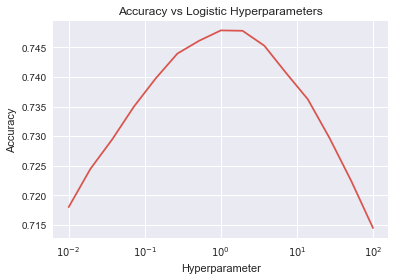

In [137]:
# Plot accuracy vs hyperparameter
plt.figure()
accuracy=plt.errorbar(params, score, color=sns.xkcd_rgb["pale red"])
plt.xlabel('Hyperparameter')
plt.xscale("log")
plt.ylabel('Accuracy')
plt.title("Accuracy vs Logistic Hyperparameters")
plt.show()

## Comments
The logistic regression performs as expected, it experiences both overfitting and underfitting at both extreme values of the hyperparameter. The parameter, c, passed to the function is the inverse regularizer weight, meaning values left of the peak represent underfitting to the train data, and values to the right of the peak are overfitting to the data.

This analysis revealed that a hyperparameter of 1 ,is optimal.

# Model Implementation
Predict the sentiment of each political party's tweets

In [112]:
# Divide Unclassified Tweets by political party 
con_tweet = unclassified_tweets.loc[(unclassified_tweets['party']=='Conservative')]
con_tweet = con_tweet.reset_index(drop=True)
lib_tweet = unclassified_tweets.loc[(unclassified_tweets['party']=='Liberal')]
lib_tweet = lib_tweet.reset_index(drop=True)
ndp_tweet = unclassified_tweets.loc[(unclassified_tweets['party']=='NDP')]
ndp_tweet = ndp_tweet.reset_index(drop=True)
oth_tweet = unclassified_tweets.loc[(unclassified_tweets['party']=='Other')]
oth_tweet = oth_tweet.reset_index(drop=True)

In [113]:
# Convert tweets into list
con_list = []
for tweet in con_tweet.text:
    con_list.append(tweet)
lib_list = []
for tweet in lib_tweet.text:
    lib_list.append(tweet)
ndp_list = []
for tweet in ndp_tweet.text:
    ndp_list.append(tweet)
oth_list = []
for tweet in oth_tweet.text:
    oth_list.append(tweet)

In [114]:
# Convert tweets into tfidf vector space in order to feed them into regression model
con_vocab = vectorizer.transform(con_list)
lib_vocab = vectorizer.transform(lib_list)
ndp_vocab = vectorizer.transform(ndp_list)
oth_vocab = vectorizer.transform(oth_list)

In [115]:
# Use regression model to predict sentiment of each tweet in each political party
con_pred = clfModel.predict(con_vocab)
lib_pred = clfModel.predict(lib_vocab)
ndp_pred = clfModel.predict(ndp_vocab)
oth_pred = clfModel.predict(oth_vocab)

In [116]:
# Define function to plot sentiment count for each party
def sentiment_plotter (sentiment, plt_title):
    objects = ('Negative','Positive')
    y_pos = np.arange(len(objects))
    performance = [sentiment.tolist().count(0),sentiment.tolist().count(4)]

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Count')
    plt.title(plt_title)

    plt.show()

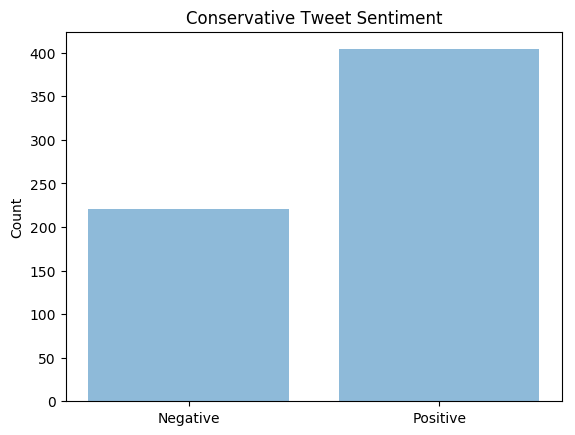

In [117]:
sentiment_plotter(con_pred,'Conservative Tweet Sentiment')

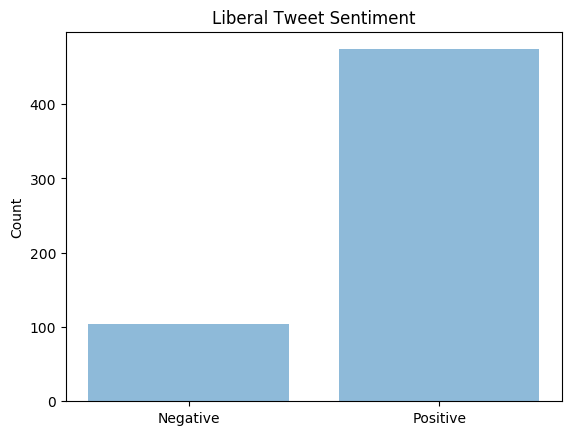

In [118]:
sentiment_plotter(lib_pred,'Liberal Tweet Sentiment')

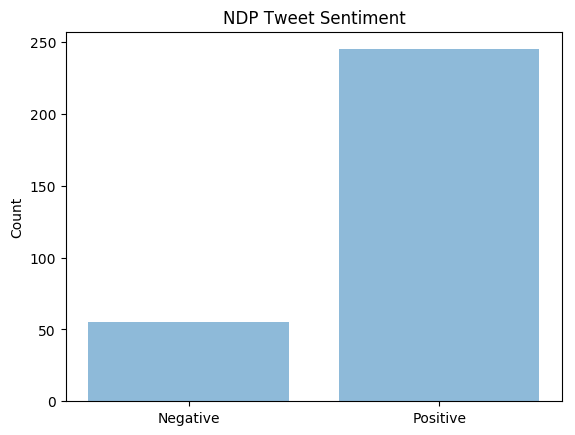

In [119]:
sentiment_plotter(ndp_pred,'NDP Tweet Sentiment')

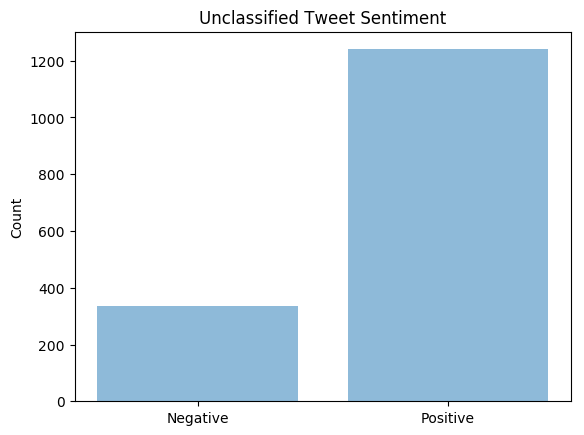

In [120]:
sentiment_plotter(oth_pred,'Unclassified Tweet Sentiment')

# Discussion
Interpretation of results